In [1]:
%matplotlib inline

import glob
from platform import python_version

import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch

In [2]:
import xarray as xr
import math
from matplotlib import pyplot as plt
import torch
import gpytorch
import matplotlib.pyplot as plt
import cf_units
import datetime

In [3]:
sea_level_dataset = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')
sea_level_dataarray = sea_level_dataset['sea_level']
#yt = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')['lat'].data
#xt = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')['long'].data
sea_level_dataarray

,Array,Chunk
Bytes,227.21 GB,22.72 MB
Shape,"(5844, 2700, 3600)","(5844, 27, 36)"
Count,10001 Tasks,10000 Chunks
Type,float32,numpy.ndarray


In [4]:
interval1 = sea_level_dataarray.sel(xt_ocean= -150, yt_ocean= 20, method="nearest").isel(time = slice(0,5844))

#This interval is half of the original data set, will be the training data output, y

timeint1 = interval1['time']


timearray1int = np.array(timeint1)
timearray11 = cf_units.date2num(timearray1int,'days since 0185-01-01 12:00:00' , calendar='julian')


#need to convert to nparray to then become a torch tensor
interval11 = np.array(interval1)

seaarray_torch = torch.FloatTensor(interval11).unsqueeze(dim=1)
print(seaarray_torch.shape)

timearray_torch = torch.FloatTensor(timearray11).unsqueeze(dim=1)

x_new = torch.cat((timearray_torch[0:500], timearray_torch[1000:1500], timearray_torch[2000:2500],timearray_torch[3000:3500]))

y_new = torch.cat((seaarray_torch[0:500], seaarray_torch[1000:1500], seaarray_torch[2000:2500], seaarray_torch[3000:3500]))

torch.Size([5844, 1])


In [9]:
sea_train = seaarray_torch[0:1000]
sea_val = seaarray_torch[1000:1500]
sea_test = seaarray_torch[1500:2500]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(sea_train)
val_arr = scaler.transform(sea_val)
test_arr = scaler.transform(sea_test)

In [15]:
#we make the data into shorter sequences, taking the feature of the time bar at an index of i and trying to predict i+1

def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    #variable wraps a tensor, and provides a backward method. 
    return x_var, y_var

In [41]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [42]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time bars")
    axes[i].set_ylabel("Scaled Sea Levels")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

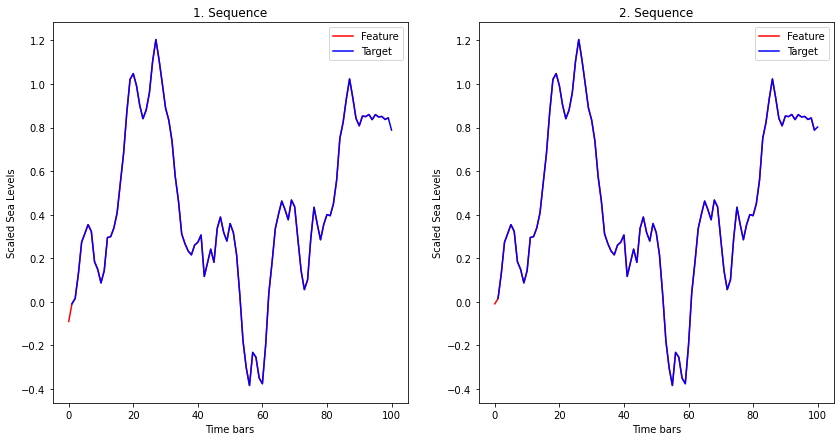

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [44]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept until the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [45]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [46]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [47]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [48]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [49]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.96. Validation loss: 1.00. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 2 Train loss: 0.91. Validation loss: 0.95. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 3 Train loss: 0.87. Validation loss: 0.90. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 4 Train loss: 0.82. Validation loss: 0.85. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 5 Train loss: 0.77. Validation loss: 0.80. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 6 Train loss: 0.74. Validation loss: 0.79. Avg future: 0.00. Elapsed time: 0.44s.
Epoch 7 Train loss: 0.74. Validation loss: 0.79. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 8 Train loss: 0.73. Validation loss: 0.78. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 9 Train loss: 0.73. Validation loss: 0.77. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 10 Train loss: 0.72. Validation loss: 0.77. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 11 Train loss: 0.72. Validation loss: 0.77. Avg future: 0.00. Elapsed time: 0.43s.
Epoch 12 Train loss: 0.72. Val

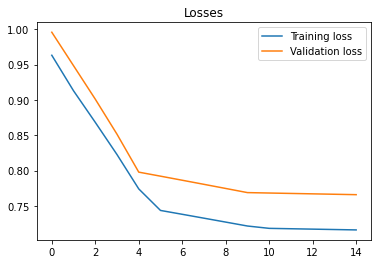

In [50]:
optimization_1.plot_losses()

Test loss 0.8361


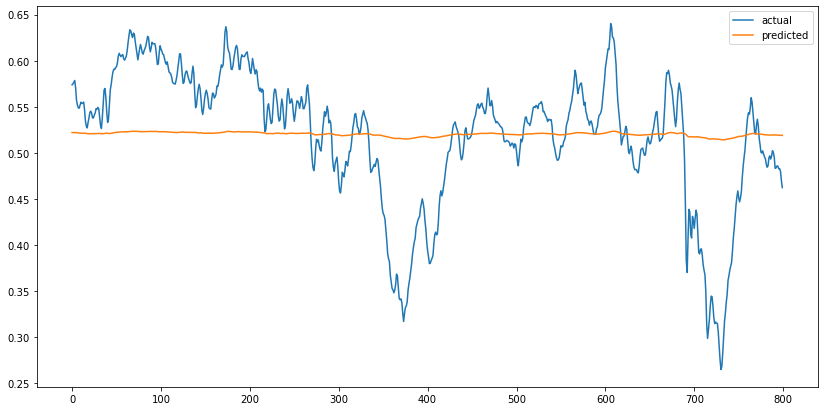

In [28]:
#plot against the training data

actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

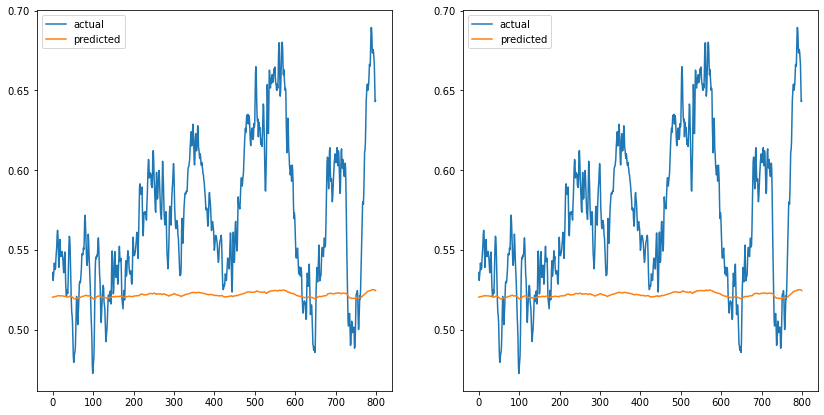

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[0:1000].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[0:3000].plot(ax=axes[1], figsize=(14, 7))

In [20]:
x_sample = x_test[0].reshape(1, -1)
y_sample = sea_test[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

ValueError: x and y must have same first dimension, but have shapes (1100,) and torch.Size([1000, 1])

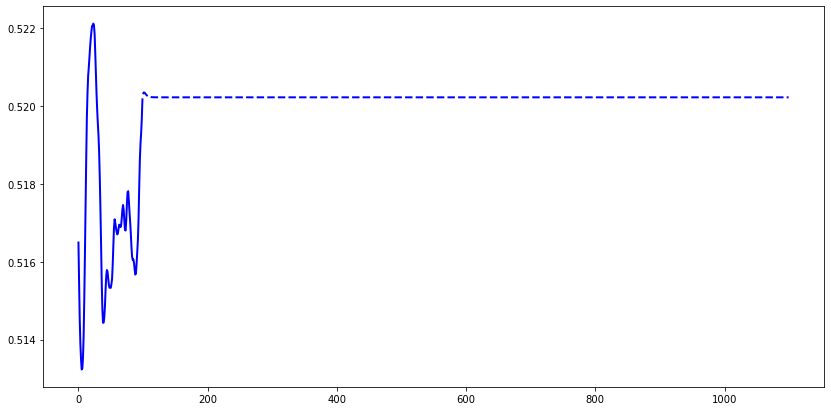

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted Sea level")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated Sea level")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual Sea level")
plt.legend()

array([[1],
       [2],
       [3],
       [4],
       [5]])